In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!pip install scikit-surprise

     |████████████████████████████████| 6.5MB 3.0MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1673655 sha256=e2e9550de8181e9bf4b91f9532f18adc06682d506d3adae143b8bcb1c111098a
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
sns.set_style("darkgrid")
from surprise.model_selection import cross_validate, KFold
pd.options.display.max_rows=10000
pd.options.display.max_columns=50

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
def preprocess(file_path):
    df = pd.read_csv(file_path, header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
    df['Rating'] = df['Rating'].astype(float)

    df_id = df.Rating.isnull()
    df_id = df_id[df_id == True].reset_index()
    movie_np,movie_id = [],0

    for i,j in zip(df_id['index'][1:],df_id['index'][:-1]):
        movie_id += 1
        temp = np.full((1,i-j-1), movie_id)
        movie_np = np.append(movie_np, temp)

    last_record = np.full((1,len(df) - df_id.iloc[-1, 0] - 1),movie_id+1)
    movie_np = np.append(movie_np, last_record)

    data = df[df.Rating.notnull()]
    data['Movie_Id'] = movie_np.astype(int)
    data['Cust_Id'] = data['Cust_Id'].astype(int)
    return data

In [0]:
path = F"/content/gdrive/My Drive/Software Design for DS - Group/Data Set/"
data = preprocess(path+"combined_data_1.txt")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
def sample_balance(sample, path):
    print("Removing users with less than 30 reviews...")
    cid = sample.groupby(["Cust_Id"])["Movie_Id"].agg(['count']).sort_values(by = "count", ascending=False).reset_index()
    cid["%"] = cid["count"].cumsum().apply(lambda x: x/cid["count"].sum())
    cust_list = cid['Cust_Id'].tolist()[:200000]
    sample = sample.loc[sample['Cust_Id'].isin(cust_list)] 
    print("Done") 

    print("Removing movies with less than 1000 reviews...")
    mid = sample.groupby(["Movie_Id"])["Cust_Id"].agg(['count']).sort_values(by = "count", ascending=False).reset_index()
    mid["%"] = mid["count"].cumsum().apply(lambda x: x/mid["count"].sum())
    mid_list = mid['Movie_Id'].tolist()[:1655] #1000
    sample = sample.loc[data['Movie_Id'].isin(mid_list)] 
    print("Done") 

    print("---------")
    movie_num = len(sample.Movie_Id.unique()) 
    user_num = len(sample.Cust_Id.unique())
    print("In our data set, there is a total number of", movie_num, "movies and", user_num ,"users.")
    fig, ax = plt.subplots(figsize=(8,6))
    sample.groupby(["Rating"])["Cust_Id"].agg(['count']).sort_values(by = "count").plot.bar(ax=ax,colormap='Paired')
    #print("Now, we have a balanced data set with relatively even amount of ratings in five categories.")    
    print("Plot of the distribution of Ratings from 1 to 5:")
    
    movie_info = pd.read_csv(path+'movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
    movie_info.set_index('Movie_Id', inplace = True)
    
    
    movie_groupby = sample.groupby('Movie_Id')['Rating'].agg(["count","mean"])
    movie_groupby.index = movie_groupby.index.map(int)

    user_groupby = sample.groupby('Cust_Id')['Rating'].agg(["count","mean"])
    user_groupby.index = user_groupby.index.map(int)
    pivot_table = pd.pivot_table(sample,values='Rating',index='Cust_Id',columns='Movie_Id')
    
    return sample, movie_info, movie_groupby, user_groupby, pivot_table

Removing users with less than 30 reviews...
Done
Removing movies with less than 1000 reviews...
Done
---------
In our data set, there is a total number of 1655 movies and 200000 users.
Plot of the distribution of Ratings from 1 to 5:


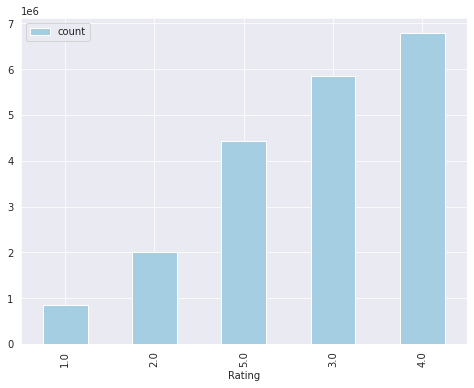

In [0]:
sample, movie_info, movie_groupby, user_groupby, pivot_table = sample_balance(data, path)

In [0]:
sample.to_csv(path+"sample.csv")
movie_info.to_csv(path+"movie_info.csv")
movie_groupby.to_csv(path+"movie_groupby.csv")
user_groupby.to_csv(path+"user_groupby.csv")
pivot_table.to_csv(path+"pivot_table.csv")


In [0]:
movie_info.to_csv(path+"movie_info.csv")

In [0]:
class SVD_Model:
    
    def __init__(self, df_title):
        self.reader = Reader()
        self.df_title = df_title
        self.df_rating = None
        self.data = None
        self.svd = SVD()
    
    def train(self, df):
        self.df_rating = df
        self.data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], self.reader)
        trainset = self.data.build_full_trainset()
        self.svd.fit(trainset)
        print("Trained Model Successfully!")
        
    def evaluate(self, n_folds = 3):
        cv = cross_validate(self.svd, self.data, measures=['RMSE', 'MAE'], cv=n_folds, verbose=True)
        print(cv)
    
    def recommend(self, user_id, n_movies = 10):
        user_movies = self.df_title.copy()
        user_movies = user_movies.reset_index()
        try:
          user_movies['Estimate_Score'] = user_movies['Movie_Id'].apply(lambda x: self.svd.predict(user_id, x).est)
          user_movies = user_movies.drop('Movie_Id', axis = 1)
          user_movies = user_movies.sort_values('Estimate_Score', ascending=False)
          return user_movies[:n_movies]
        except:
          print("user id not valid")
    
    def compare(self, user_id):
        user_movies = self.df_title.copy()
        user_movies = user_movies.reset_index()
        user_movies['Estimate_Score'] = user_movies['Movie_Id'].apply(lambda x: self.svd.predict(user_id, x).est)
        user_ratings = self.df_rating[self.df_rating.Cust_Id == user_id]
        user_movies = pd.merge(user_movies, user_ratings, how = "inner", left_on = ["Movie_Id"], right_on = ["Movie_Id"])
        user_movies = user_movies[["Year",	"Name", "Rating", "Estimate_Score"]]
        user_movies = user_movies.sort_values('Rating', ascending=False)
        return user_movies

In [0]:
movie_info2 = pd.read_csv(path+"movie_info.csv")
print(movie_info2.iloc[0])

Movie_Id                  1
Year                   2003
Name        Dinosaur Planet
Name: 0, dtype: object


In [0]:
import pickle

In [0]:
svd_model = SVD_Model(movie_info)
svd_model.train(sample)

Trained Model Successfully!


In [0]:
svd_model.evaluate()

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8695  0.8696  0.8701  0.8697  0.0002  
MAE (testset)     0.6742  0.6742  0.6746  0.6743  0.0002  
Fit time          898.50  918.15  913.38  910.01  8.37    
Test time         138.47  138.07  112.79  129.78  12.01   
{'test_rmse': array([0.86947768, 0.86961339, 0.87005016]), 'test_mae': array([0.67419873, 0.67419007, 0.6745651 ]), 'fit_time': (898.4983098506927, 918.1456887722015, 913.3808403015137), 'test_time': (138.47318816184998, 138.0693187713623, 112.78888726234436)}


In [0]:
recommended_movies = svd_model.recommend(1238184, 20)
recommended_movies

,Year,Name,Estimate_Score
2451,2001.0,Lord of the Rings: The Fellowship of the Ring,5.000000
3727,1993.0,So I Married an Axe Murderer,4.926255
3149,2000.0,Monty Python: The Life of Python,4.839576
1494,2001.0,Alias: Season 1,4.792482
4471,2003.0,Love Actually,4.724546
1434,2001.0,Wallace & Gromit in Three Amazing Adventures,4.693136
3347,2001.0,George Carlin: Complaints and Grievances,4.662285
3953,1952.0,The Quiet Man,4.645508
3768,2004.0,Wonderfalls: The Complete Series,4.622287
2113,2002.0,Firefly,4.570539


In [0]:
profile = svd_model.compare(1653438)
print("Profile of Customer "+str(1653438)+":")
profile

Profile of Customer 1653438:


,Year,Name,Rating,Estimate_Score
116,1964.0,A Fistful of Dollars,5.0,4.267747
89,1997.0,Liar Liar,5.0,3.177848
125,1999.0,Trigun,5.0,4.023497
123,1995.0,Things to Do in Denver When You're Dead,5.0,4.001981
119,1984.0,This Is Spinal Tap,5.0,4.614507
115,2001.0,Lord of the Rings: The Fellowship of the Ring,5.0,4.316648
113,1979.0,Alien: Collector's Edition,5.0,4.439119
111,1996.0,Scream,5.0,3.454599
106,2004.0,Super Size Me,5.0,4.194667
97,1998.0,Lock,5.0,4.130305


In [0]:
recommended_movies = svd_model.recommend(822109, 20)
recommended_movies

,Year,Name,Estimate_Score
4097,2002.0,Angel: Season 4,5.000000
1946,2002.0,Gilmore Girls: Season 3,5.000000
2161,2000.0,CSI: Season 1,5.000000
2567,2004.0,Stargate SG-1: Season 8,5.000000
773,2003.0,Foyle's War: Set 2,5.000000
1202,1963.0,The Andy Griffith Show: Vol 3: Andy Discovers ...,5.000000
3455,2004.0,Lost: Season 1,5.000000
2113,2002.0,Firefly,5.000000
3957,2003.0,Monk: Season 2,5.000000
4237,2000.0,Inu-Yasha,5.000000


In [0]:
profile = svd_model.compare(822109)
print("Profile of Customer "+str(822109)+":")
profile

Profile of Customer 822109:


,Year,Name,Rating,Estimate_Score
0,1999.0,American Beauty,5.0,3.777285
6,2004.0,Man on Fire,5.0,4.548861
14,2003.0,Pirates of the Caribbean: The Curse of the Bla...,5.0,4.712861
21,1998.0,T-Rex: Back to the Cretaceous: IMAX,5.0,3.791556
22,1990.0,Ghost,5.0,4.195552
26,1992.0,Forever Young,5.0,4.039109
27,1988.0,Beaches,5.0,4.418704
31,1999.0,The Sixth Sense,5.0,4.814946
32,1995.0,While You Were Sleeping,5.0,4.591731
3,1991.0,Fried Green Tomatoes,5.0,4.558784


In [0]:
recommended_movies = svd_model.recommend(823519, 20)
recommended_movies

,Year,Name,Estimate_Score
620,1997.0,Armageddon,5.000000
2161,2000.0,CSI: Season 1,4.948157
2941,1999.0,Friends: Season 6,4.920124
1255,1994.0,The Best of Friends: Vol. 4,4.917746
1946,2002.0,Gilmore Girls: Season 3,4.905429
1494,2001.0,Alias: Season 1,4.845260
3077,1994.0,The Best of Friends: Season 2,4.834095
312,2000.0,Pay It Forward,4.810338
2937,1994.0,The Best of Friends: Season 1,4.785544
4305,1999.0,The Sixth Sense,4.751751


In [0]:
profile = svd_model.compare(823519)
print("Profile of Customer "+str(823519)+":")
profile

Profile of Customer 823519:


,Year,Name,Rating,Estimate_Score
121,2003.0,Bad Boys II,5.0,4.254098
131,2003.0,The Matrix: Reloaded,5.0,3.863163
103,2003.0,The Rundown,5.0,4.354342
82,1995.0,Bad Boys,5.0,4.436863
100,1991.0,The Silence of the Lambs,5.0,4.476152
99,1993.0,Falling Down,5.0,3.662281
30,2000.0,The Perfect Storm,5.0,4.292192
97,1995.0,Braveheart,5.0,4.603051
144,1999.0,The Sixth Sense,5.0,4.751751
96,2003.0,Dr. Seuss' The Cat in the Hat,5.0,3.245879


In [0]:
import pickle
outfile = path+"svd_model.sav"
with open(outfile, 'wb') as pickle_file:
    pickle.dump(svd_model, pickle_file)
#pickle.dump(svd_model, path+"svd_model.sav")

In [0]:
class Pearson_Model:
    
    def __init__(self, df_title, df_p, df_movie_summary):
        self.df_title = df_title
        self.df_p = df_p
        self.df_movie_summary = df_movie_summary
           
    def recommend(self, movie_title, top_number, min_count = 0):
        
        print("For movie ({})".format(movie_title))
        print("- Top "+str(top_number)+" movies recommended based on Pearsons'R correlation - ")    
        i = int(self.df_title.index[self.df_title['Name'] == movie_title][0])
        target = self.df_p[i]
        similar_to_target = self.df_p.corrwith(target)
        corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
        corr_target.dropna(inplace = True)
        corr_target = corr_target.sort_values('PearsonR', ascending = False)
        corr_target.index = corr_target.index.map(int)
        corr_target = corr_target.join(self.df_title).join(self.df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
        print(corr_target[corr_target['count']>min_count][:top_number].to_string(index=False))

In [0]:
p_model = Pearson_Model(movie_info, pivot_table, movie_groupby)

In [0]:
p_model.recommend("The Silence of the Lambs", 10)

For movie (The Silence of the Lambs)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                               Name   count      mean
 1.000000           The Silence of the Lambs  111601  4.304630
 0.292672                               Jaws   75570  3.884068
 0.281316                        Poltergeist   39340  3.823488
 0.277739         Alien: Collector's Edition   45355  4.109800
 0.253807                     Taxi: Season 1    1033  3.617619
 0.252924                      The Godfather   61699  4.400363
 0.252136                           The Omen   19994  3.636741
 0.250405       Pulp Fiction: Bonus Material    1129  3.930027
 0.247141  The Spy Who Came In from the Cold    1286  3.716952
 0.245706                    The Sixth Sense  122257  4.313773


In [0]:
p_model.recommend("Mean Girls", 10)

For movie (Mean Girls)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                  Name  count      mean
 1.000000                            Mean Girls  82105  3.503392
 0.353736  Confessions of a Teenage Drama Queen  16907  2.936003
 0.345639                         Freaky Friday  67054  3.525875
 0.338434                    A Cinderella Story  26968  3.583766
 0.335077           Candyman 3: Day of the Dead   1787  2.837157
 0.331053                    The Rage: Carrie 2   3446  3.054846
 0.329398    The Flintstones in Viva Rock Vegas   3793  2.492750
 0.325001                 Twilight of the Golds   1086  3.375691
 0.315504                         The Sandlot 2   5393  3.253291
 0.315182                      Wish Upon a Star   1158  3.620035


In [0]:
p_model.recommend("Sleepless in Seattle", 10)

For movie (Sleepless in Seattle)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                           Name   count      mean
 1.000000           Sleepless in Seattle   93842  3.730526
 0.407418           When Harry Met Sally   71142  4.014591
 0.391716        While You Were Sleeping   57223  3.616535
 0.385212                          Ghost  103105  3.635808
 0.378640     MVP: Most Valuable Primate    1089  3.007346
 0.364118    Three Men and a Little Lady   22062  3.152117
 0.353971             Leave it to Beaver    1341  2.601044
 0.351704         The American President   54922  3.795273
 0.335968                     Speechless    1278  3.215962
 0.334845  Touched by an Angel: Season 1    1045  3.716746


In [0]:
p_model.recommend("Batman Begins", 10)

For movie (Batman Begins)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                                   Name  count      mean
 1.000000                                          Batman Begins  43683  4.242016
 0.367855  Batman: The Animated Series: Tales of the Dark Knight   2301  3.578010
 0.351419          Batman Beyond: Tech Wars / Disappearing Inque   1062  3.839925
 0.338123        Batman: The Animated Series: Out of the Shadows   1679  3.822513
 0.331117                                       X2: X-Men United  85872  3.931980
 0.325733                     Batman Beyond: Return of the Joker   3429  3.596092
 0.310115                                              Unleashed   6505  3.654881
 0.309425                     Batman the Animated Series: Vol. 3   1033  4.178122
 0.299889                                      Road to Singapore   1458  3.540466
 0.295561                               Batman Beyond: The Movie   2418  3.736146


In [0]:
p_model.recommend("The Lion King: Special Edition", 10)

For movie (The Lion King: Special Edition)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                          Name  count      mean
 1.000000                The Lion King: Special Edition  57767  4.206935
 0.486498                     Aladdin: Platinum Edition  46131  4.188507
 0.399216                   The Hunchback of Notre Dame   1854  3.484898
 0.370409                              First Do No Harm   1201  3.580350
 0.355220                                    Pocahontas  17168  3.529765
 0.352621                                        Double   1123  3.427427
 0.345854                     Boy Meets World: Season 1   1670  3.743713
 0.342519                                      Hercules  16879  3.685823
 0.339010                            Leaving Metropolis   1141  3.311131
 0.335340  Brother Bear (Theatrical Widescreen Version)  28214  3.735805


In [0]:
outfile = path+"p_model.sav"
with open(outfile, 'wb') as pickle_file:
    pickle.dump(p_model, pickle_file)

In [4]:
import pickle
path = F"/content/gdrive/My Drive/Software Design for DS - Group/Data Set/"
loaded_svd_model = pickle.load(open(path+"svd_model.sav", 'rb'))
loaded_svd_model.recommend(1238184, 20)

AttributeError: ignored

In [0]:
loaded_p_model = pickle.load(open(path+"p_model.sav", 'rb'))
loaded_p_model.recommend("The Lion King: Special Edition", 10)

For movie (The Lion King: Special Edition)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                          Name  count      mean
 1.000000                The Lion King: Special Edition  57767  4.206935
 0.486498                     Aladdin: Platinum Edition  46131  4.188507
 0.399216                   The Hunchback of Notre Dame   1854  3.484898
 0.370409                              First Do No Harm   1201  3.580350
 0.355220                                    Pocahontas  17168  3.529765
 0.352621                                        Double   1123  3.427427
 0.345854                     Boy Meets World: Season 1   1670  3.743713
 0.342519                                      Hercules  16879  3.685823
 0.339010                            Leaving Metropolis   1141  3.311131
 0.335340  Brother Bear (Theatrical Widescreen Version)  28214  3.735805
